In [1]:
#..modified by CHUYAN at August/25/2021; calculate binned P-E/SST/subsidence/ LTS and LWP array; (annual-mean, binned 5X5degree, area-mean 
#..data, standardized data) for abrupt4XCO2 experiment, then use the sensitivity of LWP to CCFs to get a Linear regression model to predict
#..d(LWP)/dGMT..

import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import PyNIO as Nio
import pandas as pd

from scipy import stats
from sklearn import linear_model

In [2]:
#..retrieve variables in abrupt-4xCO2 experiment

fpath_abr_ts    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_ta    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ta/gn/latest/ta_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_ps    = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/ps/gn/latest/ps_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_wap   = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/wap/gn/latest/wap_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_clivi = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/clivi/gn/latest/clivi_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_clwvi = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/clwvi/gn/latest/clwvi_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_abr_tas   = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'

fpath_p     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/pr/gn/v20190927/pr_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'
fpath_e     = '/glade/collections/cdg/data/CMIP6/CMIP/NCAR/CESM2/abrupt-4xCO2/r1i1p1f1/Amon/evspsbl/gn/v20190927/evspsbl_Amon_CESM2_abrupt-4xCO2_r1i1p1f1_gn_000101-015012.nc'


f_ts        = netCDF4.Dataset(fpath_abr_ts,'r')
f_ta        = netCDF4.Dataset(fpath_abr_ta,'r')
f_tas       = netCDF4.Dataset(fpath_abr_tas,'r')
f_ps        = netCDF4.Dataset(fpath_abr_ps,'r')
f_wap       = netCDF4.Dataset(fpath_abr_wap,'r')
f_clivi     = netCDF4.Dataset(fpath_abr_clivi,'r')
f_clwvi     = netCDF4.Dataset(fpath_abr_clwvi,'r')

f_pr        = netCDF4.Dataset(fpath_p, 'r')
f_ev        = netCDF4.Dataset(fpath_e, 'r')

lons        = f_ts.variables['lon'][:]
lats        = f_ts.variables['lat']
times       = f_ts.variables['time']


levels      = f_ta.variables['plev']
#print(levels)

In [3]:
#..choose lat 40-85S as the Southern Ocean region
lati0 = -40.
latsi0= min(range(len(lats)), key = lambda i: abs(lats[i] - lati0))
lati1 = -85.
latsi1= min(range(len(lats)), key = lambda i: abs(lats[i] - lati1))


sfc_T       = f_ts.variables['ts']   #..T_skin, also as SST, shape in (1800, 192, 288), units in K
T_700       = f_ta.variables['ta'][:, 3,:,:]
sfc_P       = f_ps.variables['ps']   #..Units in Pa, surface Pressure

sub         = f_wap.variables['wap'][:, 5,:,:]    #..500mb downward motions
clivi       = f_clivi.variables['clivi']   #..Units in kg m^-2
clwvi       = f_clwvi.variables['clwvi']
tas         = f_tas.variables['tas']   #..2-m air Temperature, for 'gmt'

P           = f_pr.variables['pr']   #..Units in kg m^-2 s^-1 = mm *s^-1
E           = f_ev.variables['evspsbl']
print(sfc_T.shape)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if __name__ == '__main__':


(1800, 192, 288)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':


In [4]:
print(sfc_P.shape, T_700.shape)
print(tas.shape, P.shape, E.shape)

(1800, 192, 288) (1800, 192, 288)
(1800, 192, 288) (1800, 192, 288) (1800, 192, 288)


In [5]:
Precip =  np.array(P) * (24.*60.*60.)   #..Precipitation. Convert the units from kg m^-2 s^-1 -> mm*day^-1
print(np.nanmean(Precip))   #..2.74
Eva    =  np.array(E) * (24.*60.*60.)   #..evaporation, mm day^-1
print(np.nanmean(Eva))         #..2.43
print(Eva.shape)   #..variable shape in (1800, 192, 288)


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """Entry point for launching an IPython kernel.


2.737364


/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until


2.4275806
(1800, 192, 288)


In [6]:

#..Variables: LWP, tas(gmt), SST, p-e, LTS, subsidence
LWP  = np.array(clwvi) - np.array(clivi)   #..units in kg m^-2
gmt  = np.array(tas)
SST  = np.array(sfc_T)
MC  = Precip-Eva   #..Moisture Convergence calculated from P - E, Units in mm day^-1

Twp  = np.array(clwvi)
Iwp  = np.array(clivi)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  after removing the cwd from sys.path.
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys
/glade/u/ssg/ch/usr/jupyterhub/envs/np

In [7]:
#..Lower Troposphere Stability
k  = 0.286
theta_700  = np.array(T_700)* (100000./70000.)**k

#print(theta_700)

theta_skin = np.array(sfc_T)* (100000./np.array(sfc_P))**k
LTS_m  = theta_700 - theta_skin

#..Subtract the outliers in T_700 and LTS_m
LTS_e  = np.ma.masked_where(theta_700 >= 500, LTS_m)
#print(LTS_e, LTS_m)

#..Subsidence, units in Pa s^-1 at 500 hPa
Subsidence =  np.array(sub)

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  import sys


In [8]:
#..Convert variables becoming Annual-mean, Southern-Ocean region arrays

Tg  = np.zeros((150,192,288))   #..Surface air Temperature, GMT
LWP_yr  = np.zeros((150,48,288))

p_e_yr  = np.zeros((150,48,288))
SST_yr  = np.zeros((150,48,288))
SUB_yr  = np.zeros((150,48,288))
LTS_yr  = np.zeros((150,48,288))


TWP_yr  = np.zeros((150,48,288))
IWP_yr  = np.zeros((150,48,288))
#..annual mean data of LWP, Tg and CCFs

for i in range(0, 150):
    Tg[i,:,:]     = np.nanmean(gmt[i*12:(i+1)*12,:,:], axis=0)
    LWP_yr[i,:,:]  = np.nanmean(LWP[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    p_e_yr[i,:,:] = np.nanmean(MC[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SST_yr[i,:,:]    = np.nanmean(SST[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    
    LTS_yr[i,:,:]    = np.nanmean(LTS_e[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)
    SUB_yr[i,:,:]    = np.nanmean(Subsidence[i*12:(i+1)*12, latsi1:latsi0,:], axis=0)

    TWP_yr[i,:,:]  = np.nanmean(Twp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
    IWP_yr[i,:,:]  = np.nanmean(Iwp[i*12:(i+1)*12, latsi1:latsi0, :], axis=0)
print(Tg.shape, LTS_yr.shape)   #..shape in (150,48,288) or (150,192,288)



(150, 192, 288) (150, 48, 288)


In [9]:
def binned_cySouthOcean5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in SouthOcean REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Southern Ocean region from 85S 40S
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-85., -35, 5.)   #.. (10)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [10]:
def binned_cyGlobal5(S, lat, lon):
    '''
    Calculate the binned array for the mean value within 5X5 degree Bin Boxes in global REGION
    '''

    XX, YY  = np.meshgrid(lon, lat, indexing='xy')
    #..Global region from 90S 90N
    x_range  = np.arange(0., 364, 5.)   #..number:73
    y_range  = np.arange(-90., 90, 5.)   #..(37)
    
    xbins, ybins = len(x_range), len(y_range)
    
    S_binned_array  = np.zeros((S.shape[0],ybins,xbins))
    
    for i in np.arange(S.shape[0]):
        S_time_step  = S[i,:,:]
        
        #..find and subtract the missing points
        ind =  np.isnan(S[i,:,:])==False
        S_binned_time , xedge, yedge, binnumber  = stats.binned_statistic_2d(XX[ind].ravel(),YY[ind].ravel(), values = S_time_step[ind].ravel(),
                                                                            statistic ='mean', bins=[xbins, ybins], expand_binnumbers =True)
        
        S_binned_array[i,:,:] = S_binned_time.T
    
    return S_binned_array


In [17]:
#..Calculate 5X5 degree binned array for P-E, SST, LTS, SUB, 2-m air Temperature(Tg) and the LWP:
lat_array0  = lats   #..192 values
lon_array0  = lons
lat_array1  = lats[latsi1:latsi0]   #..48 values

#x_range  = np.arange(0., 364, 5.)   #..number:73
#y_range  = np.arange(-85., -35, 5.)   #.. 40 S - 85 S(10)

#xbins, ybins = len(x_range), len(y_range)

Tg_yr_bin  = binned_cyGlobal5(Tg, lat_array0, lon_array0)   #..shape in (150,36,73)
LWP_yr_bin  = binned_cySouthOcean5(LWP_yr, lat_array1, lon_array0)   #..shape in (150,10,73)

SST_yr_bin  = binned_cySouthOcean5(SST_yr, lat_array1, lon_array0)

p_e_yr_bin  = binned_cySouthOcean5(p_e_yr, lat_array1, lon_array0)


LTS_yr_bin  = binned_cySouthOcean5(LTS_yr, lat_array1, lon_array0)
SUB_yr_bin  = binned_cySouthOcean5(SUB_yr, lat_array1, lon_array0)

TWP_yr_bin  = binned_cySouthOcean5(TWP_yr, lat_array1, lon_array0)
IWP_yr_bin  = binned_cySouthOcean5(IWP_yr, lat_array1, lon_array0)


print(SUB_yr_bin)   #..Tg:(150,36,73); LWP&CCFs:(150,10,73)

[[[ 1.29427356e-02  1.34720668e-02  1.16293029e-02 ...  1.32037839e-02
    1.29687957e-02  1.22913778e-02]
  [ 1.66702117e-02  1.50675938e-02  1.31096088e-02 ...  1.13521681e-02
    1.28178937e-02  1.55272158e-02]
  [ 2.36764646e-02  3.42053328e-02  3.91050209e-02 ... -7.60833176e-03
    3.76202228e-03  3.01974142e-02]
  ...
  [ 8.23934679e-06 -2.27029822e-03 -2.90525072e-03 ...  2.22464061e-03
   -9.38728344e-04  6.02749706e-04]
  [ 2.47284410e-03  9.28375686e-04  3.94504795e-03 ...  6.04383130e-03
    3.11819970e-03  5.63863994e-03]
  [ 1.95088050e-02  2.11258632e-02  2.58643258e-02 ...  1.55841986e-03
    1.02836202e-02  1.68673381e-02]]

 [[ 1.77744879e-02  1.64046774e-02  1.34290708e-02 ...  2.28190979e-02
    2.07932844e-02  1.87230284e-02]
  [ 8.26820857e-03  1.00395791e-02  1.04325399e-02 ...  1.40252579e-02
    1.03075992e-02  6.26288584e-03]
  [ 6.73480231e-03  2.06187147e-02  3.04742010e-02 ... -1.07589134e-02
   -4.76737568e-03  1.47799978e-02]
  ...
  [-7.98857429e-03 -9.3

In [13]:
def area_mean(S, lats, lons):
    
    '''..Only for 1 final value..
    '''
    GMT  = np.zeros(S.shape[0])
    for i in np.arange(S.shape[0]):
        
        S_time_step  = S[i,:,:]
        #..weighted by cos(lat):
        xlon, ylat  = np.meshgrid(lons, lats)

        weighted_metrix1 =  np.cos(np.deg2rad(ylat))   #..metrix has the same shape as tas/lwp, its value = cos(lat)
        toc1  = np.sum(weighted_metrix1)   #..total of cos(lat metrix) for global region

        S_weighted =  S_time_step * weighted_metrix1 / toc1
        
        GMT[i]  = np.nansum(S_weighted, axis=(0,1))
    
    return GMT


In [14]:
s_range  = np.arange(-90., 90, 5.)

s_range

array([-90., -85., -80., -75., -70., -65., -60., -55., -50., -45., -40.,
       -35., -30., -25., -20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,
        20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60.,  65.,  70.,
        75.,  80.,  85.])

In [15]:
#..do the area-mean for Tg and CCFs and LWP:
x_range  = np.arange(0., 364, 5.)   #..number:73
y_range  = np.arange(-85., -35, 5.) + 2.5   #.. 40 S - 85 S(10)

s_range  = np.arange(-90., 90, 5.) + 2.5 #..(36)

GMT  = area_mean(Tg_yr_bin, s_range, x_range)            #..ALL in shape : (150,)

LWP_area_yr  = area_mean(LWP_yr_bin, y_range, x_range)
SST_area_yr  = area_mean(SST_yr_bin, y_range, x_range)
p_e_area_yr  = area_mean(p_e_yr_bin, y_range, x_range)
LTS_area_yr  = area_mean(LTS_yr_bin, y_range, x_range)
SUB_area_yr  = area_mean(SUB_yr_bin, y_range, x_range)

IWP_area_yr  = area_mean(IWP_yr_bin, y_range, x_range)
TWP_area_yr  = area_mean(TWP_yr_bin, y_range, x_range)


print(SST_area_yr.shape)

(150,)


In [27]:
#..Calculate the 150* 10* 73 points metric for 'p-e' and LWP and GMT:
#..ravel binned arrays

LWP_bin_pred  = LWP_yr_bin.flatten()     #..shape in 150* 10* 73 =  109500 values
p_e_bin_pred  = p_e_yr_bin.flatten() 
SST_bin_pred  = SST_yr_bin.flatten() 

LTS_bin_pred  = LTS_yr_bin.flatten()
SUB_bin_pred  = SUB_yr_bin.flatten()

TWP_bin_pred  = TWP_yr_bin.flatten()
IWP_bin_pred  = IWP_yr_bin.flatten()
print(p_e_bin_pred.shape)   #..Tg:(150,36,73); LWP&CCFs:(150,10,73)=109500 points

#..Use 'np.repeat' and 'np.tile' to reproduce the GMT Array:

gmt_bin_pred  = GMT.repeat(730)
print(gmt_bin_pred.shape)

#..Subtract 'nan' in data, 109500 -> 101428points
#print(np.max(LTS_bin_pred), np.max(SUB_bin_pred ))

ind1 =  np.isnan(LTS_yr_bin)==False

ind3 =  np.isnan(LTS_bin_pred)==False
print(LTS_bin_pred[ind3].shape)


(109500,)
(109500,)
(101428,)


Text(0, 0.5, '$LWP_{abrupt4XCO2}$')

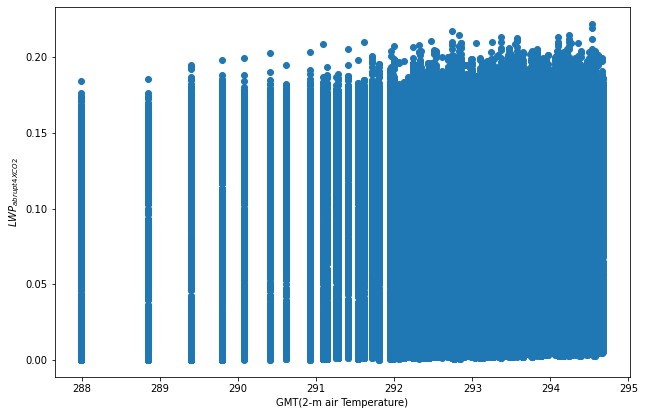

In [22]:
#..plot the Cloud Controlling Factors' and LWP(Twp/Iwp) trends with GMT trend in the 150yr abrupt4XCO2 experiment:

fig  = plt.figure(figsize = (10.3, 6.8))
ax1  = plt.axes()

yy  = np.arange(150)

plt.scatter(gmt_bin_pred , LWP_bin_pred)   #..p_e_area_yr

plt.xlabel('GMT(2-m air Temperature)')#..GMT(2-m air Temperature)
plt.ylabel('$LWP_{abrupt4XCO2}$')
#plt.ylim((0.08, 0.16))

#parameter  = np.polyfit(SUB_area_yr, LWP_area_yr, 3)
#y  = parameter[0]*p_e_area_yr + parameter[1]
#y  = parameter[0]*SUB_area_yr**3 + parameter[1]*SUB_area_yr**2 + parameter[2]*SUB_area_yr + parameter[3]
#y  = parameter[0]*p_e_area_yr**4  + parameter[1]*p_e_area_yr**3 + parameter[2]*p_e_area_yr**2 + parameter[3]*p_e_area_yr  + parameter[4]
#plt.plot(SUB_area_yr, y, 'r')

#plt.savefig('LWP_abrupt_vs_GMT_binnedgrid.png')






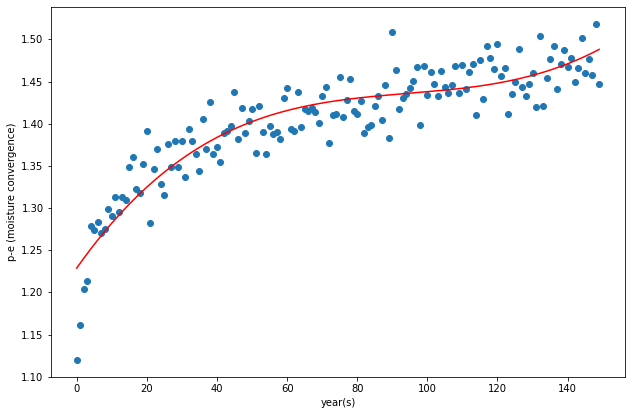

In [19]:
#..plot the p-e / LWP trends in the 150yr abrupt4XCO2 experiment:
fig  = plt.figure(figsize = (10.3, 6.8))
ax1  = plt.axes()

yy  = np.arange(150)

plt.scatter(yy, p_e_area_yr)   #..p_e_area_yr

plt.xlabel('year(s)')#..GMT(2-m air Temperature)
plt.ylabel('p-e (moisture convergence)')
#plt.ylim((0.08, 0.16))

parameter  = np.polyfit(yy, p_e_area_yr, 3)
#y  = parameter[0]*p_e_area_yr + parameter[1]
y  = parameter[0]*yy**3 + parameter[1]*yy**2 + parameter[2]*yy  + parameter[3]

plt.plot(yy , y, 'r')

plt.savefig('p_e_abrupt_vs_year.png')




In [16]:
#..Standardized data:

GMT_afpre  = GMT
GMT_afpre  = (GMT - np.mean(GMT))  / np.std(GMT)

LWP_afpre  = LWP_area_yr
LWP_afpre =  (LWP_area_yr - np.mean(LWP_area_yr) )/np.std(LWP_area_yr)


SST_afpre  = SST_area_yr
SST_afpre =  (SST_area_yr - np.mean(SST_area_yr)) /np.std(SST_area_yr)

p_e_afpre =  p_e_area_yr
p_e_afpre =  (p_e_area_yr - np.mean(p_e_area_yr)) /np.std(p_e_area_yr)

LTS_afpre  = LTS_area_yr
LTS_afpre =  (LTS_area_yr - np.nanmean(LTS_area_yr)) /np.nanstd(LTS_area_yr)

SUB_afpre  = SUB_area_yr
SUB_afpre  = (SUB_area_yr - np.mean(SUB_area_yr)) /np.std(SUB_area_yr)

#..Subtract 'nan' in data, 72270 -> 66598points
ind2 =  np.isnan(LTS_area_yr)==False  
print(ind2)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


In [17]:
print(GMT.reshape(1,-1))
print(GMT.reshape(1,-1).shape)

[[287.98450144 288.84127353 289.39978971 289.79727796 290.07546541
  290.40387476 290.60601608 290.92211662 290.92250645 291.08699636
  291.13732379 291.25918554 291.27440439 291.40411975 291.54002528
  291.60588236 291.71690058 291.79623979 291.94191079 291.99826489
  292.00196471 291.80573794 291.9795851  292.05781345 291.96317747
  291.96849138 292.12250773 292.29156882 292.24515199 292.17543299
  292.32958307 292.24094867 292.33878104 292.24775949 292.32256873
  292.3799163  292.50293577 292.46593901 292.43096295 292.45049558
  292.60991742 292.52955887 292.56990281 292.67073989 292.77556263
  292.82838225 292.67707219 292.89060685 292.76974062 292.74312549
  292.80957885 292.69302757 292.83127755 292.74595109 292.73577145
  292.84279769 292.92241187 292.96820488 293.00228676 292.84954743
  292.91286045 293.04645425 293.00039919 293.10275151 293.12400304
  293.24808943 293.19198053 292.98674681 293.03354265 293.13554609
  293.18385632 293.12716202 293.18535001 293.26824752 293.2747

In [29]:
#..linear regreesion of Cloud Controlling Factors (CCF) to GMT:

regr = linear_model.LinearRegression()
re_LWP = regr.fit(gmt_bin_pred[ind3].reshape(-1,1), LWP_bin_pred[ind3])

print(re_LWP.coef_)
print(re_LWP.intercept_)

regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
regr3 = linear_model.LinearRegression()
regr4 = linear_model.LinearRegression()
re_SST = regr1.fit(gmt_bin_pred[ind3].reshape(-1,1), SST_bin_pred[ind3])
re_p_e = regr2.fit(gmt_bin_pred[ind3].reshape(-1,1), p_e_bin_pred[ind3])
re_LTS = regr3.fit(gmt_bin_pred[ind3].reshape(-1,1), LTS_bin_pred[ind3])

re_SUB = regr4.fit(gmt_bin_pred[ind3].reshape(-1,1), SUB_bin_pred[ind3])
print(re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_ )

dX_dTg  = [re_SST.coef_, re_p_e.coef_, re_LTS.coef_, re_SUB.coef_]


[0.00182187]
-0.42777840179932847
[1.46286075] [0.06640843] [0.02302676] [0.00010079]


In [31]:
coef1  = np.load('sensitivity_4ccfs.npy')
intercept1  = np.load('intercept1.npy')

predict_aLWP2aGMT  = np.dot(coef1.reshape(1,-1), dX_dTg)

In [32]:
print(predict_aLWP2aGMT)

[[0.00437447]]


In [19]:
#..Ravel binned array / Standardized data ARRAY

LWP_predi  = LWP_yr_bin.flatten() 
#LWP_predi =  (LWP_predi - np.mean(LWP_predi) )/np.std(LWP_predi)

SST_predi  = SST_yr_bin.flatten()  
#SST_predi =  (SST_predi - np.mean(SST_predi)) /np.std(SST_predi)

p_e_predi =  p_e_yr_bin.flatten()
#p_e_predi =  (p_e_predi - np.mean(p_e_predi)) /np.std(p_e_predi)

LTS_predi  = LTS_yr_bin.flatten()
#LTS_predi =  (LTS_predi - np.nanmean(LTS_predi)) /np.nanstd(LTS_predi)

SUB_predi  = SUB_yr_bin.flatten()
#SUB_predi  = (SUB_predi - np.mean(SUB_predi)) /np.std(SUB_predi)

print(np.max(LTS_predi), np.max(SUB_predi))

#..Subtract 'nan' in data, 72270 -> 66598points
ind1 =  np.isnan(LTS_yr_bin)==False

ind3 =  np.isnan(LTS_predi)==False
print(ind3)

nan 0.15457522993286452
[ True  True  True ...  True  True  True]


In [20]:
#..Multiple linear regreesion of Liquid water path to CCF Cloud Controlling Factors:

X  = np.array([SST_predi[ind3] ,p_e_predi[ind3] ,LTS_predi[ind3], SUB_predi[ind3]])
#print(X)
print(X.shape)

result1 =  linear_model.LinearRegression()
result1 =  result1.fit(X.T, LWP_predi[ind3])
print(result1.coef_)
print(result1.intercept_)

result1.score(X.T, LWP_predi[ind3])

(4, 101428)
[ 0.00247279  0.02195972 -0.00185029  0.03064677]
-0.5703846160444894


0.7960323118311011

In [21]:
#..Multiple linear regreesion of Liquid water path to CCF Cloud Controlling Factors:

X2  = np.array([SST_predi[ind3], p_e_predi[ind3]])

result2 =  linear_model.LinearRegression()
result2 =  result2.fit(X2.T, LWP_predi[ind3])
print(result2.coef_)
print(result2.intercept_)

result2.score(X2.T, LWP_predi[ind3])

[0.002371   0.02301657]
-0.5702744742003424


0.7803327029145396

In [22]:
coef_abrupt1 = result1.coef_

coef1  = np.load('sensitivity_4ccfs.npy')
intercept1  = np.load('intercept1.npy')

coef_abrupt1

array([ 0.00247279,  0.02195972, -0.00185029,  0.03064677])

In [23]:
print(coef1)

[ 0.0022244   0.01740707 -0.00166793  0.02882105]


(150,)
(1, 150)


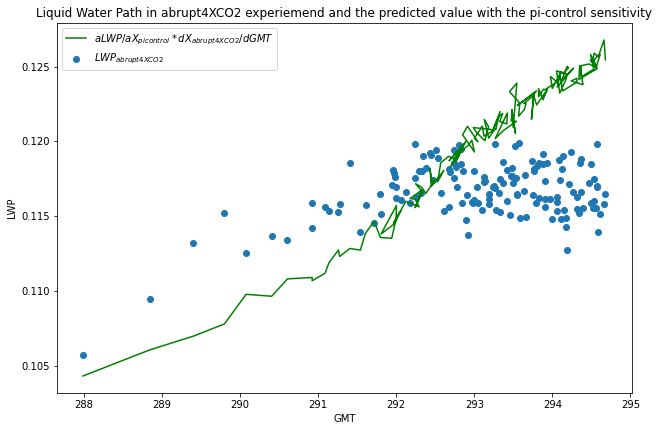

In [34]:
#..draw the plot for 'abrupt4' experiment's LWP and the predicted LWP from linear Regression Model trained in 'pi-control'

fig2  = plt.figure(figsize = (10.3, 6.8))
ax2  = plt.axes()

plt.scatter(GMT, LWP_area_yr, label='$LWP_{abrupt4XCO2}$')

XX  = np.array([SST_area_yr, p_e_area_yr, LTS_area_yr, SUB_area_yr])
#print(XX.shape)

yr =  np.dot(coef1.reshape(1,-1), XX)
predicted_LWP  = yr + intercept1
#print(yr)

print(np.array(GMT).shape)
print(np.array(predicted_LWP).shape)

plt.plot(GMT,predicted_LWP.flatten(), "g", label='$aLWP/aX_{picontrol}*{dX_{abrupt4XCO2}/dGMT}$')
#plt.ylim((0.105, 0.120))


plt.xlabel('GMT')
plt.ylabel('LWP')
plt.title("Liquid Water Path in abrupt4XCO2 experiemend and the predicted value with the pi-control sensitivity")

plt.legend()
plt.savefig("Linear_regression_abrupt.png")

In [37]:
np.array(dX_dTg).reshape(-1,1)

dLWP_DTg  = np.dot(coef1.reshape(1,-1), np.array(dX_dTg).reshape(-1,1))
print(dLWP_DTg)

[[0.00437447]]
